In [1]:
import io
import subprocess
from os.path import join, dirname, abspath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cns import data_utils as cdu
import cns

# auto reload modules
%load_ext autoreload
%autoreload 2

In [2]:
cns_file_data = """sample_id, chrom, start, end, CN1, CN2
s1, chr19, 1000000, 3000000, 1,
s1, chr19, 3000000, 12000000, 1, 1
s1, chr19, 12000000, 14000000, , 1
s1, chr19, 14000000, 21000000, 3, 1
s1, chr19, 21000000, 25000000, 3, 
s1, chr19, 28000000, 58500000, 3,
s2, chr19, 1000000, 24000000, 2,
s2, chr19, 29000000, 58000000, 0,
"""

cns_df = pd.read_csv(io.StringIO(cns_file_data.strip()), sep=',\s*', engine='python')
cns_df
chr19_segs={"chr19": cns.genome_to_segments()["chr19"]}

In [3]:
def create_Latex_fig(code, name):
    full_latex = r"""
\documentclass{standalone}
\usepackage{booktabs}
\usepackage{multirow}
\begin{document}
%s
\end{document}""" % code
    file_path = abspath(join(cdu.docs_path, f"{name}.tex"))
    with open(file_path, "w") as f:
        f.write(full_latex)
    print(f"Saved {file_path}")
    parent_dir = dirname(file_path)
    res = subprocess.run(["pdflatex", "-output-directory", parent_dir, file_path], timeout=2)
    print(res)
    print(f"Compiled {file_path.replace('.tex', '.pdf')}")

In [4]:
def latex_cns_table(cns_df, name, column_format=None, index=False, title=None):
    # Convert to LaTeX and render
    latex_table = cns_df.to_latex(index=index, float_format="%.2f", bold_rows=False, column_format=column_format)\
        .replace("sample_id", "sample")\
        .replace(r"_", r" ")\
        .replace("cn", "CN")    
    if title is not None:
        c_count = len(cns_df.columns) if not index else len(cns_df.columns) + 1
        title_tex = "\\hline\n\\multicolumn{%i}{|c|}{\\textbf{%s}}\\\\\n\\hline \n" % (c_count, title)
        latex_table = latex_table.replace("\\toprule", title_tex).replace("\\midrule", "\\hline").replace("\\bottomrule", "\\hline")
    create_Latex_fig(latex_table, name)

In [5]:
latex_cns_table(cns_df, "cns_raw_df", "|l|c|c|c|c|c|", title="raw copy number segments")

Saved D:\Ubuntu\CNSistent\docs\files\cns_raw_df.tex
CompletedProcess(args=['pdflatex', '-output-directory', 'D:\\Ubuntu\\CNSistent\\docs\\files', 'D:\\Ubuntu\\CNSistent\\docs\\files\\cns_raw_df.tex'], returncode=0)
Compiled D:\Ubuntu\CNSistent\docs\files\cns_raw_df.pdf


In [6]:
def plot_bars(ax, cns_df, column, color, height, offset, label, alpha=1):
    sel_df = cns_df[~cns_df[column].isna()]
    y = sel_df[column].values + offset
    x = sel_df["start"].values
    width = (sel_df["end"] - sel_df["start"]).values
    ax.barh(y, width, height=height, left=x, color=color, label=label, alpha=alpha)

def cns_sid(cns_df, sample_id):
    return cns_df[cns_df["sample_id"] == sample_id]

def plot_util(ax):
    max_x = cns.hg19.chr_lens["chr19"]
    pad_x = 60000000 - max_x
    ax.set_xlim(-pad_x, max_x+pad_x)
    ax.set_yticks(np.arange(-1, 5))   
    ax.set_ylim(-1, 4)
    ax.set_ylabel('copy number')
    # set tick labels to 0 Mb, 10 Mb, ..., 60 Mb
    ax.set_xticks(np.arange(0, 70000000, 10000000))
    ax.set_xticklabels([f"{i//1000000} Mb" for i in np.arange(0, 70000000, 10000000)]) 


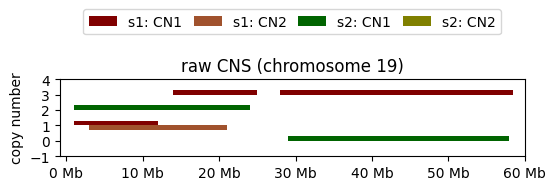

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=100)
colors = ["maroon", "sienna", "darkgreen", "olive"]
plot_util(ax)
ax.set_title('raw CNS (chromosome 19)')
plot_bars(ax, cns_sid(cns_df, "s1"), "CN1", colors[0], .3, .15, "s1: CN1")
plot_bars(ax, cns_sid(cns_df, "s1"), "CN2", colors[1], .3, -.15, "s1: CN2")
plot_bars(ax, cns_sid(cns_df, "s2"), "CN1", colors[2], .3, .15, "s2: CN1")
dummy = cns_sid(cns_df, "s2").copy()
dummy["end"] = dummy["start"]
plot_bars(ax, dummy, "CN1", colors[3], .3, .15, "s2: CN2")
# dummy here to make sure color is correct,
ax.legend(ncols=4, loc='upper center', bbox_to_anchor=(0.5, 2), columnspacing=.85)
cdu.save_doc_fig("cns_raw")

In [8]:
cov_df = cns.main_coverage(cns_df, segs=chr19_segs).T.reset_index().rename(columns={"index": "feature"}).set_index("feature")	
cov_df.columns.name = r"feature"
cov_df = cov_df.loc[["cover_any_aut", "cover_both_aut"]]
cov_df.index = ["coverage (any)", "coverage (both)"]
latex_cns_table(cov_df, "coverage_df", "|l|c|c|", True, "coverage of raw segments")
cov_df

Saved D:\Ubuntu\CNSistent\docs\files\coverage_df.tex
CompletedProcess(args=['pdflatex', '-output-directory', 'D:\\Ubuntu\\CNSistent\\docs\\files', 'D:\\Ubuntu\\CNSistent\\docs\\files\\coverage_df.tex'], returncode=0)
Compiled D:\Ubuntu\CNSistent\docs\files\coverage_df.pdf


feature,s1,s2
coverage (any),0.921714,0.879433
coverage (both),0.270595,0.0


In [9]:
cns_fill_df = cns.main_fill(cns_df, add_missing_chromosomes=False)
cns_fill_df

,sample_id,chrom,start,end,CN1,CN2
0,s1,chr19,0,1000000,NaN,NaN
1,s1,chr19,1000000,3000000,1.0,NaN
2,s1,chr19,3000000,12000000,1.0,1.0
3,s1,chr19,12000000,14000000,NaN,1.0
4,s1,chr19,14000000,21000000,3.0,1.0
5,s1,chr19,21000000,25000000,3.0,NaN
6,s1,chr19,25000000,28000000,NaN,NaN
7,s1,chr19,28000000,58500000,3.0,NaN
8,s1,chr19,58500000,59128983,NaN,NaN
9,s2,chr19,0,1000000,NaN,NaN


In [10]:
cns_imp_df = cns.main_impute(cns_fill_df)
latex_cns_table(cns_imp_df, "cns_imp_df", "|l|c|c|c|c|c|", title="imputed copy number segments")
cns_imp_df

Saved D:\Ubuntu\CNSistent\docs\files\cns_imp_df.tex
CompletedProcess(args=['pdflatex', '-output-directory', 'D:\\Ubuntu\\CNSistent\\docs\\files', 'D:\\Ubuntu\\CNSistent\\docs\\files\\cns_imp_df.tex'], returncode=0)
Compiled D:\Ubuntu\CNSistent\docs\files\cns_imp_df.pdf


,sample_id,chrom,start,end,CN1,CN2
0,s1,chr19,0,13000000,1,1
1,s1,chr19,13000000,59128983,3,1
2,s2,chr19,0,26500000,2,0
3,s2,chr19,26500000,59128983,0,0


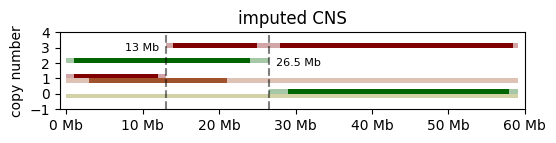

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=100)
plot_util(ax)
ax.set_title('imputed CNS')
plot_bars(ax, cns_sid(cns_imp_df, "s1"), "CN1", colors[0], .3, .15, "s1: CN1", alpha=.35)
plot_bars(ax, cns_sid(cns_imp_df, "s1"), "CN2", colors[1], .3, -.15, "s1: CN2", alpha=.35)
plot_bars(ax, cns_sid(cns_imp_df, "s2"), "CN1", colors[2], .3, .15, "s2: CN1", alpha=.35)
plot_bars(ax, cns_sid(cns_imp_df, "s2"), "CN2", colors[3], .3, -.15, "s2: CN2", alpha=.35)
plot_bars(ax, cns_sid(cns_df, "s1"), "CN1", colors[0], .3, .15, "s1: CN1")
plot_bars(ax, cns_sid(cns_df, "s1"), "CN2", colors[1], .3, -.15, "s1: CN2")
plot_bars(ax, cns_sid(cns_df, "s2"), "CN1", colors[2], .3, .15, "s2: CN1")
plot_bars(ax, cns_sid(cns_df, "s2"), "CN2", colors[3], .3, -.15, "s2: CN2")
ax.axvline(13000000, color='k', linestyle='--', alpha=.5)
ax.text(13000000, 3, '  13 Mb  ', color='k', fontsize=8, ha='right', va='center')
ax.axvline(26500000, color='k', linestyle='--', alpha=.5)
ax.text(26500000, 2, '  26.5 Mb  ', color='k', fontsize=8, ha='left', va='center')
cdu.save_doc_fig("cns_imputed")

In [12]:
chr19_gaps = {"chr19": cns.tuples_to_segments(cns.hg19_gaps)["chr19"]}
merged_chr19_gaps = cns.merge_segments(chr19_gaps)
chr19_gaps_df = cns.segments_to_cns_df(merged_chr19_gaps)[["chrom", "start", "end"]]
latex_cns_table(chr19_gaps_df, "chr19_gaps_df", "|l|c|c|c|c|", False, "known gaps in chr19")
chr19_gaps_df

Saved D:\Ubuntu\CNSistent\docs\files\chr19_gaps_df.tex
CompletedProcess(args=['pdflatex', '-output-directory', 'D:\\Ubuntu\\CNSistent\\docs\\files', 'D:\\Ubuntu\\CNSistent\\docs\\files\\chr19_gaps_df.tex'], returncode=0)
Compiled D:\Ubuntu\CNSistent\docs\files\chr19_gaps_df.pdf


,chrom,start,end
0,chr19,0,60000
1,chr19,7346004,7396004
2,chr19,8687198,8737198
3,chr19,20523415,20573415
4,chr19,24631782,27731782
5,chr19,59118983,59128983


In [13]:
def segs_to_mask(ax, segs_df):
	for i, row in segs_df.iterrows():
		ax.fill_between([row["start"], row["end"]], -1, 5, color='#EEEEAA')
		ax.axvline(x=row["start"], color='k', linestyle='--', linewidth=.5)
		ax.axvline(x=row["end"], color='k', linestyle='--', linewidth=.5)

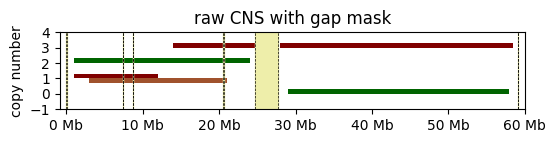

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=100)
plot_util(ax)
ax.set_title('raw CNS with gap mask')
plot_bars(ax, cns_sid(cns_df, "s1"), "CN1", colors[0], .3, .15, "s1: CN1")
plot_bars(ax, cns_sid(cns_df, "s1"), "CN2", colors[1], .3, -.15, "s1: CN2")
plot_bars(ax, cns_sid(cns_df, "s2"), "CN1", colors[2], .3, .15, "s2: CN1")
segs_to_mask(ax, chr19_gaps_df)
cdu.save_doc_fig("cns_raw_mask")

In [15]:
segs_with_gaps = cns.main_segment(chr19_segs, chr19_gaps, filter_size=100000)
segs_with_gaps_df = cns.segments_to_cns_df(segs_with_gaps)[["chrom", "start", "end"]]
latex_cns_table(segs_with_gaps_df, "segs_with_gaps_filter_df", "|l|c|c|", False, "segments with filtered gaps")
segs_with_gaps_df

Saved D:\Ubuntu\CNSistent\docs\files\segs_with_gaps_filter_df.tex
CompletedProcess(args=['pdflatex', '-output-directory', 'D:\\Ubuntu\\CNSistent\\docs\\files', 'D:\\Ubuntu\\CNSistent\\docs\\files\\segs_with_gaps_filter_df.tex'], returncode=0)
Compiled D:\Ubuntu\CNSistent\docs\files\segs_with_gaps_filter_df.pdf


,chrom,start,end
0,chr19,0,24631782
1,chr19,27731782,59128983


In [16]:
cov_df = cns.main_coverage(cns_df, segs=segs_with_gaps).T.reset_index().rename(columns={"index": "feature"}).set_index("feature")	
cov_df.columns.name = r"\textbf{feature}"
cov_df = cov_df.loc[["cover_any_aut", "cover_both_aut"]]
cov_df.index = ["coverage (any)", "coverage (both)"]
latex_cns_table(cov_df, "coverage_gaps_df", "|l|c|c|", True, "coverage with gaps")
cov_df

Saved D:\Ubuntu\CNSistent\docs\files\coverage_gaps_df.tex
CompletedProcess(args=['pdflatex', '-output-directory', 'D:\\Ubuntu\\CNSistent\\docs\\files', 'D:\\Ubuntu\\CNSistent\\docs\\files\\coverage_gaps_df.tex'], returncode=0)
Compiled D:\Ubuntu\CNSistent\docs\files\coverage_gaps_df.pdf


\textbf{feature},s1,s2
coverage (any),0.966139,0.928091
coverage (both),0.285566,0.0


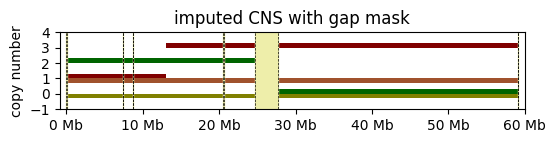

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=100)
plot_util(ax)
ax.set_title('imputed CNS with gap mask')
plot_bars(ax, cns_sid(cns_imp_df, "s1"), "CN1", colors[0], .3, .15, "s1: CN1")
plot_bars(ax, cns_sid(cns_imp_df, "s1"), "CN2", colors[1], .3, -.15, "s1: CN2")
plot_bars(ax, cns_sid(cns_imp_df, "s2"), "CN1", colors[2], .3, .15, "s2: CN1")
plot_bars(ax, cns_sid(cns_imp_df, "s2"), "CN2", colors[3], .3, -.15, "s2: CN2")

segs_to_mask(ax, chr19_gaps_df)
cdu.save_doc_fig("cns_imputed_mask")

In [24]:
cov_df = cns.main_ploidy(cns_imp_df, segs=segs_with_gaps).T.reset_index().rename(columns={"index": "feature"}).set_index("feature")	
cov_df.columns.name = r"feature"
cov_df = cov_df.loc[["ane_both_aut", "ane_any_aut", "loh_both_aut", "loh_any_aut", "imb_CN1_aut", "imb_CN2_aut"]]
cov_df.index = ["GnD (both)", "GnD (any)", "LoH (both)", "LoH (any)", "AI (CN1)",  "AI (CN2)"]
latex_cns_table(cov_df, "ploidy_df", "|l|c|c|", True, "aneuploidies and imbalances")
cov_df

Saved D:\Ubuntu\CNSistent\docs\files\ploidy_df.tex
CompletedProcess(args=['pdflatex', '-output-directory', 'D:\\Ubuntu\\CNSistent\\docs\\files', 'D:\\Ubuntu\\CNSistent\\docs\\files\\ploidy_df.tex'], returncode=0)
Compiled D:\Ubuntu\CNSistent\docs\files\ploidy_df.pdf


feature,s1,s2
GnD (both),0.0,1.0
GnD (any),0.767977,1.0
LoH (both),0.0,0.560374
LoH (any),0.0,1.0
AI (CN1),0.767977,0.439626
AI (CN2),0.0,0.0


In [19]:
cov_df = cns.main_breakage(cns_imp_df).T.reset_index().rename(columns={"index": "feature"}).set_index("feature")	
cov_df.columns.name = r"feature"
# index where ends with _aut
cov_df = cov_df.loc[[x for x in cov_df.index if x.endswith("_aut")]]
cov_df.index = [x.replace("_aut", "") for x in cov_df.index]
# replace _CN1 with (major), _CN2 with (CN2), _total_cn with (total)
cov_df.index = [x.replace("_CN1", " (CN1)") for x in cov_df.index]
cov_df.index = [x.replace("_CN2", " (CN2)") for x in cov_df.index]
cov_df.index = [x.replace("_total_cn", " (total)") for x in cov_df.index]

# divide segsize by 1e6
latex_cns_table(cov_df, "signatures", "|l|c|c|", True, "CN breakpoints")
cov_df

Saved D:\Ubuntu\CNSistent\docs\files\signatures.tex
CompletedProcess(args=['pdflatex', '-output-directory', 'D:\\Ubuntu\\CNSistent\\docs\\files', 'D:\\Ubuntu\\CNSistent\\docs\\files\\signatures.tex'], returncode=0)
Compiled D:\Ubuntu\CNSistent\docs\files\signatures.pdf


feature,s1,s2
breaks (CN1),1,1
step (CN1),2.0,2.0
breaks (CN2),0,0
step (CN2),0,0
breaks (total),1,1
step (total),2.0,2.0


In [20]:
binned_segs = cns.main_segment(segs_with_gaps, split_size=5000000)
breaks = cns.segments_to_breaks(binned_segs)["chr19"]
print("breaks", breaks)
print("Left size", breaks[1] - breaks[0])
print("Right size", breaks[-1] - breaks[-2])


breaks [0, 4926356, 9852713, 14779069, 19705426, 24631782, 27731782, 32964649, 38197516, 43430383, 48663249, 53896116, 59128983]
Left size 4926356
Right size 5232867


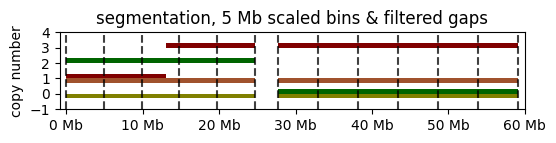

In [21]:
bin_none_df = cns.main_aggregate(cns_imp_df, binned_segs, "none", cn_columns=["CN1", "CN2"])
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=100)
ax.set_title('segmentation, 5 Mb scaled bins & filtered gaps')
plot_util(ax)
plot_bars(ax, cns_sid(bin_none_df, "s1"), "CN1", colors[0], .3, .15, "s1: CN1")
plot_bars(ax, cns_sid(bin_none_df, "s1"), "CN2", colors[1], .3, -.15, "s1: CN2")
plot_bars(ax, cns_sid(bin_none_df, "s2"), "CN1", colors[2], .3, .15, "s2: CN1")
plot_bars(ax, cns_sid(bin_none_df, "s2"), "CN2", colors[3], .3, -.15, "s2: CN2")

for brekapoint in breaks:
    ax.axvline(x=brekapoint, color='k', linestyle='--', alpha=.75)
cdu.save_doc_fig("cns_segmented")

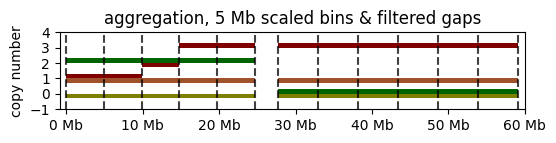

In [22]:
bin_res_df = cns.main_aggregate(cns_imp_df, binned_segs, cn_columns=["CN1", "CN2"])
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=100)
ax.set_title('aggregation, 5 Mb scaled bins & filtered gaps')
plot_util(ax)
plot_bars(ax, cns_sid(bin_res_df, "s1"), "CN1", colors[0], .3, .15, "s1: CN1")
plot_bars(ax, cns_sid(bin_res_df, "s1"), "CN2", colors[1], .3, -.15, "s1: CN2")
plot_bars(ax, cns_sid(bin_res_df, "s2"), "CN1", colors[2], .3, .15, "s2: CN1")
plot_bars(ax, cns_sid(bin_res_df, "s2"), "CN2", colors[3], .3, -.15, "s2: CN2")

for brekapoint in breaks:
    ax.axvline(x=brekapoint, color='k', linestyle='--', alpha=.75)
cdu.save_doc_fig("cns_aggregated")

In [23]:
s1_table = (
    bin_res_df.query("sample_id == 's1'")[["CN1", "CN2"]].reset_index(drop=True)
    .rename(columns={"CN2": "s1-CN2", "CN1": "s1-CN1"})
    .T
)
s2_table = (
    bin_res_df.query("sample_id == 's2'")[["CN1", "CN2"]].reset_index(drop=True)
    .rename(columns={"CN2": "s2-CN2", "CN1": "s2-CN1"})
    .T
)
feat_table = pd.concat([s1_table, s2_table], axis=0)
feat_table.columns = [f"I{i}" for i, x in enumerate(feat_table.columns)]
feat_table = feat_table.reset_index().rename(columns={"index": "layer"})
columns = "|l|" + "c|" * len(feat_table.columns)
latex_cns_table(feat_table, "features_df", columns, False, "input layers for deep learning on 5 Mb masked segments")
feat_table

Saved D:\Ubuntu\CNSistent\docs\files\features_df.tex
CompletedProcess(args=['pdflatex', '-output-directory', 'D:\\Ubuntu\\CNSistent\\docs\\files', 'D:\\Ubuntu\\CNSistent\\docs\\files\\features_df.tex'], returncode=0)
Compiled D:\Ubuntu\CNSistent\docs\files\features_df.pdf


,layer,I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10
0,s1-CN1,1.0,1.0,1.722266,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
1,s1-CN2,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,s2-CN1,2.0,2.0,2.000000,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,s2-CN2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
